In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Задание 1. Закон всемирного тяготения

Считаем, что центры шаров расположены на оси $x$. Нужно посчитать интеграл:

$$
F = G\rho_1\rho_2\int d^3 r_1 d^3 r_2 \dfrac{(r_2 - r_1)}{|r_2 - r_2|^3}
$$

1.9780493879324757e+20
Относительная погрешность по оси x: 5.99e-03
Погрешность по оси y: -1.02e+16
Погрешность по оси z: -1.84e+15


Processing items: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Коэффициент наклона графика: -0.48


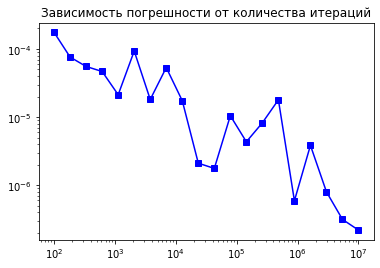

In [34]:
from tqdm import tqdm
force_real_value_x = 1.98997e20

def generate_points_in_sphere(R, N):
    np.random.seed(333)
    X = np.random.normal(size=(3, N))
    norms = np.linalg.norm(X, axis=0)
    directions = X / norms
    U = np.random.uniform(0.0, 1.0, size=N)
    radii = R * U**(1/3)
    return directions * radii

def force_numerical(N):
    
    # Constants
    G = 6.67e-11
    m1 = 6e24
    m2 = 7.35e22
    r = 384467000
    rho1 = 5520
    rho2 = 3346
    R1 = 6367000
    R2 = 1737000
    
    r1 = generate_points_in_sphere(R1, N)
    r2 = generate_points_in_sphere(R2, N)
    
    denominator = (np.sqrt((r + r2[0,:] - r1[0,:])**2 + (r2[1,:] - r1[1,:])**2 + (r2[2,:] - r1[2,:])**2)**3)
    
    coeff = G*rho1*rho2*(4/3*np.pi)**2 * R1**3 * R2**3
    
    force_x = coeff*np.mean((r + r2[0,:]-r1[0,:])/denominator)
    force_y = coeff*np.mean((r2[1,:]-r1[1,:])/denominator)
    force_z = coeff*np.mean((r2[2,:]-r1[2,:])/denominator)
    return np.array([force_x, force_y, force_z])


force_x, force_y, force_z = force_numerical(10000)
print(force_x)
print(f'Относительная погрешность по оси x: {abs(force_x - force_real_value_x)/force_real_value_x:.2e}')
print(f'Погрешность по оси y: {force_y:.2e}')
print(f'Погрешность по оси z: {force_z:.2e}')

n_points = 20
N_array = np.logspace(2, 7, n_points).astype('int')
eps = np.zeros(n_points)
for j, n in tqdm(enumerate(N_array), total = len(N_array), desc = "Processing items"):
    force_x, force_y, force_z = force_numerical(n)
    eps[j] = abs(force_z/force_real_value_x)

plt.title('Зависимость погрешности от количества итераций')
plt.plot(N_array, eps, color = 'blue', ls = '-', marker = 's')
plt.xscale('log')
plt.yscale('log')
popt = np.polyfit(np.log(N_array), np.log(eps), deg = 1)
print(f'Коэффициент наклона графика: {popt[0]:.2f}')

# Задание 2. Рассеяние нейтронов

In [60]:
# Длина свободного пробега нейтрона равна 1/sigma_tot
h = 5 #толщина пластинки в cm
sigma_el = 1 # сечение упругого рассеяния в cm2
sigma_inel = 0.1 # сечение неупругого рассеяния в cm2
sigma_tot = sigma_el + sigma_inel
# Длина свободного пробега нейтрона равна  l = 1/(sigma_tot)
# Если считаем, что смещение нейтрона подчиняется распределению 1/l*exp(-r/l), то его смещение x можно генерировать как:
# x = -1/(sigma_tot)*ln(ksi), ksi \in U(0,1)

N = 1000 #Число падающих нейтронов
N_t = 0 # число прошедших нейтронов
N_ref = 0 # число отраженных нейтронов
N_abs = 0 # число поглощенных нейтронов
max_iter = 1000 #Максимальное количество циклов в for
for k in range(N):
    x, n = 0, 1
    for i in range(max_iter):
        ksi = np.random.random()
        r = -1/(sigma_tot)*np.log(ksi)
        x += r*n
        if (x < 0):
            N_ref += 1
            break
        elif (x > h):
            N_t += 1
            break
        if ksi < sigma_inel/sigma_tot:
            N_abs += 1
            break
        else:
            n = 2*ksi - 1
            
print(f'Число прошедших нейтронов : {N_t}')
print(f'Число отраженных нейтронов : {N_ref}')
print(f'Число поглощенных нейтронов : {N_abs}')

Число прошедших нейтронов : 75
Число отраженных нейтронов : 313
Число поглощенных нейтронов : 612


# Задание 3. Случайное блуждание

Среднее значение расстояния: 10.033984953147977


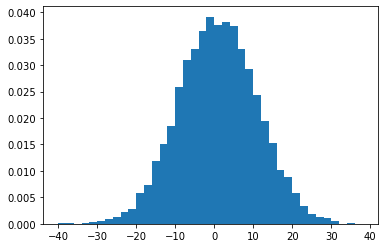

In [89]:
def random_walk(T : int, N : int):
    x_array = np.zeros(N)
    for n in range(N):
        x = 0
        for j in range(T):
            ksi = np.random.random()
            if ksi <= 0.5:
                x -= 1
            else:
                x += 1
        x_array[n] = x
    return x_array

xs = random_walk(100, 10000)

print(f'Среднее значение расстояния: {np.std(xs)}')
plt.hist(xs, bins = np.arange(-40, 40, 2), density = True)
plt.show()

# Задание 4. Семплирование по Гиббсу

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3751.00it/s]


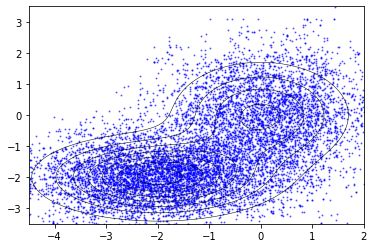

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Добавлен импорт tqdm
import scipy.stats as stats

delta = 0.025
X, Y = np.meshgrid(np.arange(-4.5, 2.0, delta), np.arange(-3.5, 3.5, delta))

z1 = stats.multivariate_normal([0, 0], [[1.0, 0], [0, 1.0]])
z2 = stats.multivariate_normal([-2, -2], [[1.5, 0], [0, 0.5]])

def z(x):
    return 0.4 * z1.pdf(x) + 0.6 * z2.pdf(x)

Q = stats.norm(loc=0, scale=0.5)

N = 10000
r = np.array([0.0, 0.0])  # Инициализация начальной точки
samples = np.zeros((N, 2))  # Изменена форма для удобства (N, 2)

for i in tqdm(range(N)):
    for j in range(2):
        rq = Q.rvs() + r[j]
        current_z = z(r)
        if j == 0:
            new_point = np.array([rq, r[1]])
        else:
            new_point = np.array([r[0], rq])
        a = z(new_point) / current_z
        if np.random.rand() < min(a, 1.0):
            r[j] = rq
    samples[i] = r  # Сохраняем после обновления обеих координат

# Построение контура
Z = 0.4 * z1.pdf(np.dstack((X, Y))) + 0.6 * z2.pdf(np.dstack((X, Y)))

fig, ax = plt.subplots()
ax.contour(X, Y, Z.squeeze(), colors='black', linewidths=0.5)  # Удален лишний размер
ax.scatter(samples[:, 0], samples[:, 1], color='blue', s=1, alpha=0.5)
ax.set_xlim(-4.5, 2.0)
ax.set_ylim(-3.5, 3.5)
plt.show()

# Задание 5. Алгоритм Метрополиса-Хастингса - генерация выборок

Доля отвергнутых кандидатов: 0.02673


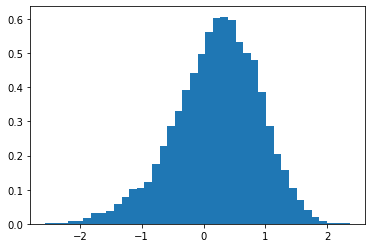

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def proba_density(x):
    
    return np.exp(-x**2)*(3 + np.cos(x) + 2*np.sin(x) + x**2)

x = 0 # Поставим очень плохое начальное приближение
B = 0.1

N = 100000

xs = np.zeros(N)
xs[0] = x

rejected = 0
for i in range(1, N):
    x_cand = xs[i-1] + np.random.uniform(-B, B)
    
    if proba_density(x_cand)/proba_density(xs[i-1]) >= 1:
        xs[i] = x_cand
        continue
    else:
        if np.random.uniform(0, 1) < proba_density(x_cand)/proba_density(xs[i-1]): # q = 1 т.к. симметричное распределение
            xs[i] = x_cand
            continue
        else:
            xs[i] = xs[i-1]
            rejected  += 1
            continue
plt.hist(xs, bins = 40, density=True)
print(f"Доля отвергнутых кандидатов: {rejected/N}")

array([0.        , 0.06399006, 0.09791138, ..., 0.47665487, 0.55728801,
       0.64700787])

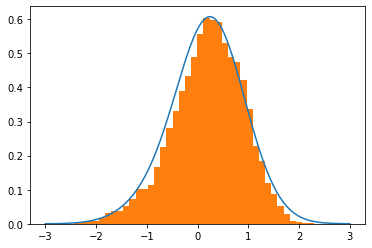

In [40]:
eps = 0.5*1e-2
i_cut = 9000

plt.plot(np.linspace(-3, 3, 200), proba_density(np.linspace(-3, 3, 200))/7)
_ = plt.hist(xs[i_cut::3], bins = 40, density = True)
xs